In [1]:
import random
import time
import os
import json

import cv2
import numpy as np

import torch
import torchvision
import torch.nn as nn
import torch.optim as optim

from PIL import Image
from IPython import display

from torchvision.transforms import transforms
import torch.utils.data
from torchsummary import summary

import matplotlib.pyplot as plt
import itertools

from pytorchCycleGANandpix2pix.models import networks as offnets
from pytorchCycleGANandpix2pix.util.image_pool import ImagePool
from pytorchCycleGANandpix2pix.util.util import tensor2im

from joint_dataset import JointDomainImageDataset

from dotmap import DotMap

device = "cuda"

# Colab Configuration (Local vs. Hosted)

In [2]:
using_google_gpus = False

train_X_loc = "./selected_data/experiment_random_1679337142.6036053/X/train" 
test_X_loc = "./selected_data/experiment_random_1679337142.6036053/X/test"

train_Y_loc = "./selected_data/experiment_random_1679337142.6036053/Y/train"
test_Y_loc = "./selected_data/experiment_random_1679337142.6036053/Y/test"

# train_Y_loc = "./selected_data/experiment_random_1679337142.6036053/X/train" # "./datasets/horse2zebra/trainA" if using_google_gpus else "./cyclegan_original_data/horse2zebra/trainA" #  # 
# test_Y_loc = "./selected_data/experiment_stratified_selection_1679231577.167669/X/test" # "./datasets/horse2zebra/testA" if using_google_gpus else "./cyclegan_original_data/horse2zebra/testA" # "./selected_data/experiment_stratified_selection_1678204517.945494/X/test" # 

# train_X_loc = "./selected_data/experiment_stratified_selection_1679231577.167669/Y/train" # "./datasets/horse2zebra/trainB" if using_google_gpus else "./cyclegan_original_data/horse2zebra/trainB" # "./selected_data/experiment_stratified_selection_1678204517.945494/Y/train" # 
# test_X_loc = "./selected_data/experiment_stratified_selection_1679231577.167669/Y/test" # "./datasets/horse2zebra/testB" if using_google_gpus else "./cyclegan_original_data/horse2zebra/testB" # "./selected_data/experiment_stratified_selection_1678204517.945494/Y/test" # 

run_data_directory = "./runs"

In [3]:
if using_google_gpus:
    from google.colab import drive
    drive.mount("/content/drive")
    vis = None
else:
    import visdom
    vis = visdom.Visdom()

Setting up a new session...


In [4]:
%cd drive/MyDrive/cyclegan

[WinError 3] The system cannot find the path specified: 'drive/MyDrive/cyclegan'
F:\Documents\Development\GitHub\advanced-computer-vision-y4\code


# Generator Architecture

In [5]:
# CINR = Convolution Instance Norm ReLU
# 3x3 convolutions with stride 1/2, 1 or 2 depending on position
# Uses reflection padding
# In the paper:
# dk denotes a k filter stride 2 with 3x3 conv
# c7s1-k denotes a k filter stride 1 with 7x7 conv
# uk denotes a k filter stride 1/2 with 3x3 conv
# Instead of using a nn.Module, this has much less overhead
def createGeneratorCINRLayer(in_ch, out_ch, stride, kernel_size, reflect_pad):
    layers = []
        
    padding = 1
    
    if reflect_pad:
        layers.append(nn.ReflectionPad2d(kernel_size // 2))
        padding = 0

    if stride < 1:
        layers.append(
            nn.ConvTranspose2d(in_ch, out_ch, kernel_size=kernel_size, stride=int(1 / stride), padding=padding, output_padding=padding, bias=True)
        )
        # layers += [
        #     nn.Upsample(scale_factor=2, mode="bilinear"), ## nn instead of bi maybe try pixelshuffle
        #     nn.ReflectionPad2d(1),
        #     nn.Conv2d(in_ch, out_ch, kernel_size=kernel_size, stride=1, padding=0)
        # ]
    else:
        layers.append(
            nn.Conv2d(in_ch, out_ch, kernel_size=kernel_size, stride=stride, padding=padding, bias=True)
        )
    
    layers += [
        nn.InstanceNorm2d(out_ch),
        nn.ReLU(True)
    ]

    return nn.Sequential(*layers)

In [6]:
# Contains 2 3x3 convolutional layers with the same number of filters on both layers
# Use reflect padding in these
# Don't use dropout
# Use instancenorm
class GeneratorResidualBlock(nn.Module):
    def __init__(self, feature_size):
        super().__init__()
        
        layers = [
            nn.ReflectionPad2d(1),
            nn.Conv2d(feature_size, feature_size, kernel_size=3, bias=True),
            nn.InstanceNorm2d(feature_size),
            nn.ReLU(True),
            # Dropout would go here if I want it
            nn.ReflectionPad2d(1),
            nn.Conv2d(feature_size, feature_size, kernel_size=3, bias=True),
            nn.InstanceNorm2d(feature_size)
        ]
        
        self.seq = nn.Sequential(*layers)
    
    def forward(self, batch):
        return batch + self.seq(batch)

In [7]:
# For the 128x128 case:
# c7s1-64, d128, d256, R256 x 6, u128, u64, c7s1-3
class Generator(nn.Module):
    def __init__(self, resnet_blocks):
        super().__init__()
        
        layers = [
            createGeneratorCINRLayer(in_ch=3, out_ch=64, stride=1, kernel_size=7, reflect_pad=True),
            createGeneratorCINRLayer(in_ch=64, out_ch=128, stride=2, kernel_size=3, reflect_pad=False),
            createGeneratorCINRLayer(in_ch=128, out_ch=256, stride=2, kernel_size=3, reflect_pad=False)
        ]
        
        # same dim all the way through
        for _ in range(resnet_blocks):
            layers.append(GeneratorResidualBlock(feature_size=256))

        layers += [ 
            createGeneratorCINRLayer(in_ch=256, out_ch=128, kernel_size=3, stride=0.5, reflect_pad=False),
            createGeneratorCINRLayer(in_ch=128, out_ch=64, kernel_size=3, stride=0.5, reflect_pad=False),

            # Last one is a bit different without the ReLU and instance norm
            nn.ReflectionPad2d(3),
            nn.Conv2d(in_channels=64, out_channels=3, stride=1, kernel_size=7, bias=True),
            nn.Tanh()
        ]
        
        self.seq = nn.Sequential(*layers)
        
    def forward(self, batch):
        return self.seq(batch)

# Discriminator Architecture

In [8]:
# CINR = Convolution Instance Normalisation Layer
# Denoted Ck where k = #filters
def createDiscriminatorCINRLayer(in_ch, out_ch, stride, apply_norm):
    layers = [
        nn.Conv2d(in_ch, out_ch, kernel_size=4, stride=stride, padding=1),
    ]

    if apply_norm:
        layers.append(
            nn.InstanceNorm2d(out_ch)
        )
    
    layers.append(
        nn.LeakyReLU(0.2, True)
    )

    return nn.Sequential(*layers)

In [9]:
class PatchDiscriminator(nn.Module):
    def __init__(self):
        super().__init__()

        layers = [
            createDiscriminatorCINRLayer(in_ch=3, out_ch=64, stride=2, apply_norm=False),
            createDiscriminatorCINRLayer(in_ch=64, out_ch=128, stride=2, apply_norm=True),
            createDiscriminatorCINRLayer(in_ch=128, out_ch=256, stride=2, apply_norm=True),
            createDiscriminatorCINRLayer(in_ch=256, out_ch=512, stride=1, apply_norm=True),
            # In the source of CycleGAN they use k=4, s=1, p=1 despite not saying this in the paper
            nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=1)
        ]

        self.seq = nn.Sequential(*layers)

    def forward(self, batch):
        return self.seq(batch)

# Comparing Architecture

In [ ]:
my_generator_arch = Generator().to(device)
summary(my_generator_arch, (3, 256, 256))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
   ReflectionPad2d-1          [-1, 3, 262, 262]               0
            Conv2d-2         [-1, 64, 256, 256]           9,472
    InstanceNorm2d-3         [-1, 64, 256, 256]               0
              ReLU-4         [-1, 64, 256, 256]               0
            Conv2d-5        [-1, 128, 128, 128]          73,856
    InstanceNorm2d-6        [-1, 128, 128, 128]               0
              ReLU-7        [-1, 128, 128, 128]               0
            Conv2d-8          [-1, 256, 64, 64]         295,168
    InstanceNorm2d-9          [-1, 256, 64, 64]               0
             ReLU-10          [-1, 256, 64, 64]               0
  ReflectionPad2d-11          [-1, 256, 66, 66]               0
           Conv2d-12          [-1, 256, 64, 64]         590,080
   InstanceNorm2d-13          [-1, 256, 64, 64]               0
             ReLU-14          [-1, 256,

In [ ]:
their_generator_arch = offnets.define_G(
    input_nc=3,
    output_nc=3,
    ngf=64,
    netG="resnet_9blocks",
    norm="instance"
).to(device)
summary(their_generator_arch, (3, 256, 256))

initialize network with normal
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
   ReflectionPad2d-1          [-1, 3, 262, 262]               0
            Conv2d-2         [-1, 64, 256, 256]           9,472
    InstanceNorm2d-3         [-1, 64, 256, 256]               0
              ReLU-4         [-1, 64, 256, 256]               0
            Conv2d-5        [-1, 128, 128, 128]          73,856
    InstanceNorm2d-6        [-1, 128, 128, 128]               0
              ReLU-7        [-1, 128, 128, 128]               0
            Conv2d-8          [-1, 256, 64, 64]         295,168
    InstanceNorm2d-9          [-1, 256, 64, 64]               0
             ReLU-10          [-1, 256, 64, 64]               0
  ReflectionPad2d-11          [-1, 256, 66, 66]               0
           Conv2d-12          [-1, 256, 64, 64]         590,080
   InstanceNorm2d-13          [-1, 256, 64, 64]               0
        

In [ ]:
my_discriminator_arch = PatchDiscriminator().to(device)
summary(my_discriminator_arch, (3, 256, 256))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 128, 128]           3,136
         LeakyReLU-2         [-1, 64, 128, 128]               0
            Conv2d-3          [-1, 128, 64, 64]         131,200
    InstanceNorm2d-4          [-1, 128, 64, 64]               0
         LeakyReLU-5          [-1, 128, 64, 64]               0
            Conv2d-6          [-1, 256, 32, 32]         524,544
    InstanceNorm2d-7          [-1, 256, 32, 32]               0
         LeakyReLU-8          [-1, 256, 32, 32]               0
            Conv2d-9          [-1, 512, 31, 31]       2,097,664
   InstanceNorm2d-10          [-1, 512, 31, 31]               0
        LeakyReLU-11          [-1, 512, 31, 31]               0
           Conv2d-12            [-1, 1, 30, 30]           8,193
Total params: 2,764,737
Trainable params: 2,764,737
Non-trainable params: 0
---------------------------

In [ ]:
their_discriminator_arch = offnets.define_D(
    input_nc=3,
    ndf=64,
    netD="basic",
    norm="instance"
).to(device)
summary(their_discriminator_arch, (3, 256, 256))

initialize network with normal
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 128, 128]           3,136
         LeakyReLU-2         [-1, 64, 128, 128]               0
            Conv2d-3          [-1, 128, 64, 64]         131,200
    InstanceNorm2d-4          [-1, 128, 64, 64]               0
         LeakyReLU-5          [-1, 128, 64, 64]               0
            Conv2d-6          [-1, 256, 32, 32]         524,544
    InstanceNorm2d-7          [-1, 256, 32, 32]               0
         LeakyReLU-8          [-1, 256, 32, 32]               0
            Conv2d-9          [-1, 512, 31, 31]       2,097,664
   InstanceNorm2d-10          [-1, 512, 31, 31]               0
        LeakyReLU-11          [-1, 512, 31, 31]               0
           Conv2d-12            [-1, 1, 30, 30]           8,193
Total params: 2,764,737
Trainable params: 2,764,737
Non-trainable params

# CycleGAN

In [10]:
class HistoryBuffer:
    def __init__(self, max_size):
        self.max_size = max_size
        self.buffer = []
        
    def __len__(self):
        return len(self.buffer)

    def _make_space(self, max_del_size):
        current_available_space = self.max_size - len(self)
        del_size = max(0, max_del_size - current_available_space)

        if del_size == 0:
            return

        del_indexes = random.sample(range(0, len(self)), del_size)

        for del_idx in del_indexes:
            del self.buffer[del_idx]

    def add(self, batch):
        self._make_space(len(batch))

        for item in batch:
            self.buffer.append(item.detach())

    def sample_batch(self, batch_size):
        return torch.stack(random.sample(self.buffer, batch_size))

    def randomise_existing_batch(self, existing_batch):
        if len(self) < existing_batch.shape[0] / 2:
            return existing_batch
        
        new_batch = []

        for item in existing_batch:
            if random.uniform(0, 1) < 0.5:
                new_batch.append(item.detach())
            else:
                new_batch.append(self.buffer[random.randint(0, len(self) - 1)])

        return torch.stack(new_batch)

In [11]:
class CycleGAN:
    def __init__(self, device, blocks, init=True, start_epoch=0, save_folder=None):
        self.block_count = blocks

        self.G = Generator(blocks).to(device)
        self.F = Generator(blocks).to(device)
        
        self.D_X = PatchDiscriminator().to(device)
        self.D_Y = PatchDiscriminator().to(device)

        if init:
            self._initialise_weights()

        self.fake_X_buffer = HistoryBuffer(50)
        self.fake_Y_buffer = HistoryBuffer(50)

        self.gan_X_loss = nn.MSELoss().to(device)
        self.gan_Y_loss = nn.MSELoss().to(device)

        self.cycle_X_loss = nn.L1Loss().to(device)
        self.cycle_Y_loss = nn.L1Loss().to(device)

        self.identity_loss = nn.L1Loss().to(device)

        self.G_opt = torch.optim.Adam(self.G.parameters(), lr=0.0002, betas=(0.5, 0.999))
        self.F_opt = torch.optim.Adam(self.F.parameters(), lr=0.0002, betas=(0.5, 0.999))

        self.D_X_opt = torch.optim.Adam(self.D_X.parameters(), lr=0.0002, betas=(0.5, 0.999))
        self.D_Y_opt = torch.optim.Adam(self.D_Y.parameters(), lr=0.0002, betas=(0.5, 0.999))

        def lambda_rule(epoch):
            lr_l = 1.0 - max(0, epoch - 99) / float(101)
            return lr_l

        self.G_opt_scheduler = torch.optim.lr_scheduler.LambdaLR(self.G_opt, lr_lambda=lambda_rule)
        self.F_opt_scheduler = torch.optim.lr_scheduler.LambdaLR(self.F_opt, lr_lambda=lambda_rule)
        self.D_X_opt_scheduler = torch.optim.lr_scheduler.LambdaLR(self.D_X_opt, lr_lambda=lambda_rule)
        self.D_Y_opt_scheduler = torch.optim.lr_scheduler.LambdaLR(self.D_Y_opt, lr_lambda=lambda_rule)

        self.save_folder = save_folder if save_folder is not None else f"./runs/{time.time()}"
        os.makedirs(self.save_folder, exist_ok=True)
        self.start_epoch = start_epoch

    def _initialise_weights(self):
        def applicator(m):
            classname = m.__class__.__name__
            if hasattr(m, 'weight') and (classname.find('Conv') != -1 or classname.find('Linear') != -1):
                torch.nn.init.normal_(m.weight.data, 0.0, 0.02)

                if hasattr(m, 'bias') and m.bias is not None:
                    torch.nn.init.constant_(m.bias.data, 0.0)
            
            elif classname.find('BatchNorm2d') != -1:  # BatchNorm Layer's weight is not a matrix; only normal distribution applies.
                torch.nn.init.normal_(m.weight.data, 1.0, 0.02)
                torch.nn.init.constant_(m.bias.data, 0.0)
        
        self.G.apply(applicator)
        self.F.apply(applicator)
        self.D_X.apply(applicator)
        self.D_Y.apply(applicator)

    def _step_learning_rate(self, name, scheduler, optimiser):
        previous_lr = optimiser.param_groups[0]["lr"]
        scheduler.step()
        new_lr = optimiser.param_groups[0]["lr"]
        print(f"Updated {name} learning rate from {previous_lr} to {new_lr}")

    def step_learning_rates(self):
        self._step_learning_rate("G_opt", self.G_opt_scheduler, self.G_opt)
        self._step_learning_rate("F_opt", self.F_opt_scheduler, self.F_opt)
        self._step_learning_rate("D_X_opt", self.D_X_opt_scheduler, self.D_X_opt)
        self._step_learning_rate("D_Y_opt", self.D_Y_opt_scheduler, self.D_Y_opt)

    def apply(self, tensors, x_to_y):
        model = self.G if x_to_y else self.F
        model.eval()

        with torch.no_grad():
            processed_tensors = model(tensors.to(device).detach())
        
        model.train()
        return processed_tensors.detach().cpu()

    def save(self, epoch):
        folder = f"{self.save_folder}/{epoch}"
        os.makedirs(folder, exist_ok=True)

        torch.save({
            "epoch": epoch,
            "G": self.G.state_dict(),
            "F": self.F.state_dict(),
            "D_X": self.D_X.state_dict(),
            "D_Y": self.D_Y.state_dict(),
            "G_opt": self.G_opt.state_dict(),
            "F_opt": self.F_opt.state_dict(),
            "D_X_opt": self.D_X_opt.state_dict(),
            "D_Y_opt": self.D_Y_opt.state_dict(),
            "fake_X_buffer": self.fake_X_buffer.buffer,
            "fake_Y_buffer": self.fake_Y_buffer.buffer
        }, f"{folder}/checkpoint.tar")

        torch.save(self.G.state_dict(), f"{folder}/G.pth")
        torch.save(self.F.state_dict(), f"{folder}/F.pth")
    
    @staticmethod
    def load(save_folder, epoch_dir, device, blocks):
        checkpoint_path = f"{save_folder}/{epoch_dir}/checkpoint.tar"
        checkpoint = torch.load(checkpoint_path)

        cyclegan = CycleGAN(device, blocks, init=False, start_epoch=checkpoint["epoch"], save_folder=save_folder)

        cyclegan.G.load_state_dict(checkpoint["G"])
        cyclegan.D_X.load_state_dict(checkpoint["D_X"])
        cyclegan.F.load_state_dict(checkpoint["F"])
        cyclegan.D_Y.load_state_dict(checkpoint["D_Y"])

        cyclegan.G_opt.load_state_dict(checkpoint["G_opt"])
        cyclegan.G_opt_scheduler.last_epoch = cyclegan.start_epoch

        cyclegan.D_X_opt.load_state_dict(checkpoint["D_X_opt"])
        cyclegan.D_X_opt_scheduler.last_epoch = cyclegan.start_epoch

        cyclegan.F_opt.load_state_dict(checkpoint["F_opt"])
        cyclegan.F_opt_scheduler.last_epoch = cyclegan.start_epoch

        cyclegan.D_Y_opt.load_state_dict(checkpoint["D_Y_opt"])
        cyclegan.D_Y_opt_scheduler.last_epoch = cyclegan.start_epoch

        cyclegan.fake_X_buffer.buffer = [x.to(device) for x in checkpoint["fake_X_buffer"]]
        cyclegan.fake_Y_buffer.buffer = [y.to(device) for y in checkpoint["fake_Y_buffer"]]

        cyclegan.G.train()
        cyclegan.D_X.train()
        cyclegan.F.train()
        cyclegan.D_Y.train()

        print(f"Models and buffers loaded from {checkpoint_path}")

        return cyclegan

# Data Loading

In [12]:
train_dataset = JointDomainImageDataset(train_X_loc, train_Y_loc, train=True)
test_dataset = JointDomainImageDataset(test_X_loc, test_Y_loc, train=False)

In [13]:
def revert_normalisation(tensor):
    return (tensor.permute(1, 2, 0) + 1) / 2

In [14]:
test_xs = []
test_ys = []

for i in random.sample(range(0, len(test_dataset)), 16):
    x, y = test_dataset[i]
    test_xs.append(x)
    test_ys.append(y)

test_xs = torch.stack(test_xs)
test_ys = torch.stack(test_ys)

In [15]:
if vis is not None:
    vis.images(torch.stack([revert_normalisation(x).permute(2, 0, 1) for x in test_xs]), nrow=4, opts={"title": "X_test originals"})
    vis.images(torch.stack([revert_normalisation(y).permute(2, 0, 1) for y in test_ys]), nrow=4, opts={"title": "Y_test originals"})

In [16]:
test_img = test_dataset[random.randint(0, len(test_dataset))][0]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


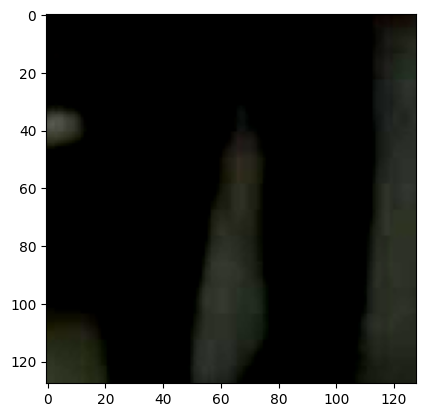

In [17]:
plt.imshow(test_img.permute(1, 2, 0))

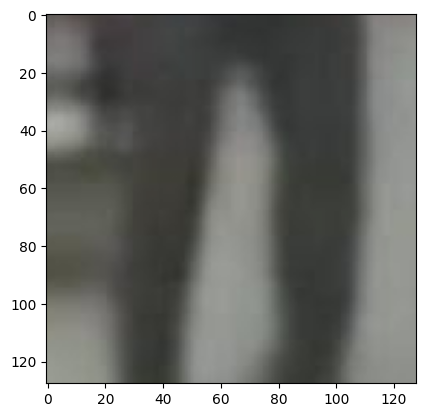

In [18]:
plt.imshow(revert_normalisation(test_img))

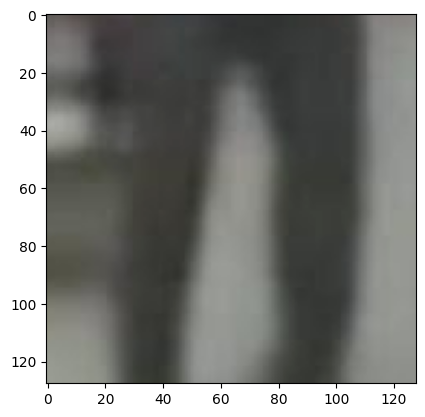

In [19]:
plt.imshow(tensor2im(test_img.unsqueeze(0)))

# Training

In [20]:
batch_size = 1
epochs = 200
lambda_weight = 10
lambda_idt = 0.5
blocks = 6

checkpoint_instance_dir = "1679338115.1399138"
checkpoint_epoch_dir = "100"

In [21]:
dataloader = torch.utils.data.DataLoader(
    dataset=train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=1
)

In [22]:
if checkpoint_instance_dir is not None and checkpoint_epoch_dir is not None:
    cyclegan = CycleGAN.load(f"./runs/{checkpoint_instance_dir}", f"{checkpoint_epoch_dir}", device, blocks)
else:
    cyclegan = CycleGAN(device, blocks)

Models and buffers loaded from ./runs/1679338115.1399138/100/checkpoint.tar


In [23]:
with open(f"{cyclegan.save_folder}/info_{checkpoint_epoch_dir}.json", "w+") as fp:
    json.dump({
        "block_count": cyclegan.block_count,
        "data_folders": {
            "train_X": train_X_loc,
            "test_X": test_X_loc,
            "train_Y": train_Y_loc,
            "test_Y": test_Y_loc
        },
        "batch_size": batch_size,
        "max_epochs": epochs,
        "start_epoch": cyclegan.start_epoch,
        "lambda_weight": lambda_weight,
        "lambda_idt": lambda_idt,
        "checkpoint": {
            "instance": checkpoint_instance_dir,
            "epoch": checkpoint_epoch_dir
        }
    }, fp, indent=2)

In [24]:
if cyclegan.start_epoch != 0:
    print(f"Resuming training from epoch {cyclegan.start_epoch + 1}")
else:
    print("Starting training from scratch")

for epoch in range(cyclegan.start_epoch + 1, epochs + 1):
    cyclegan.G.train()
    cyclegan.D_X.train()
    cyclegan.F.train()
    cyclegan.D_Y.train()

    batch_start_time = time.time()
    epoch_start_time = time.time()

    cum_D_X_loss = 0
    cum_G_fool_loss = 0
    cum_G_cycle_loss = 0

    cum_D_Y_loss = 0
    cum_F_fool_loss = 0
    cum_F_cycle_loss = 0

    ep_D_X_loss = 0
    ep_G_fool_loss = 0
    ep_G_cycle_loss = 0

    ep_D_Y_loss = 0
    ep_F_fool_loss = 0
    ep_F_cycle_loss = 0

    for batch_no, (org_x, org_y) in enumerate(dataloader):
        # model.set_inputs
        org_x = org_x.to(device)
        org_y = org_y.to(device)

        # model.forward
        fake_y = cyclegan.G(org_x)
        cycled_x = cyclegan.F(fake_y)

        fake_x = cyclegan.F(org_y)
        cycled_y = cyclegan.G(fake_x)

        # set_requires_grad netD_A, netD_B, False
        for param in cyclegan.D_X.parameters():
            param.requires_grad = False

        for param in cyclegan.D_Y.parameters():
            param.requires_grad = False

        # optG zero grad
        cyclegan.G_opt.zero_grad()
        cyclegan.F_opt.zero_grad()

        # model.backward_G
        # COPIED 
        idt_X = cyclegan.G(org_y)
        loss_idt_X = cyclegan.identity_loss(idt_X, org_y)

        idt_Y = cyclegan.F(org_x)
        loss_idt_Y = cyclegan.identity_loss(idt_Y, org_x)
        # END COPIED

        G_fool = cyclegan.D_X(fake_y) # should this be fake_x? 
        G_fool_loss = cyclegan.gan_X_loss(G_fool, torch.ones_like(G_fool))
        F_fool = cyclegan.D_Y(fake_x)
        F_fool_loss = cyclegan.gan_Y_loss(F_fool, torch.ones_like(F_fool))
        
        # Do the X -> Y -> X images look like they belong in X (and Y etc)
        G_cycle_loss = cyclegan.cycle_X_loss(cycled_x, org_x)
        F_cycle_loss = cyclegan.cycle_Y_loss(cycled_y, org_y)

        G_loss = G_fool_loss + lambda_weight * G_cycle_loss + lambda_weight * lambda_idt * loss_idt_X
        F_loss = F_fool_loss + lambda_weight * F_cycle_loss + lambda_weight * lambda_idt * loss_idt_Y

        G_loss.backward()
        F_loss.backward()

        # optG step
        cyclegan.G_opt.step()
        cyclegan.F_opt.step()

        # set_requires_grad D_X, netD_B, True
        for param in cyclegan.D_X.parameters():
            param.requires_grad = True

        for param in cyclegan.D_Y.parameters():
            param.requires_grad = True

        # optD zero grad
        cyclegan.D_X_opt.zero_grad()
        cyclegan.D_Y_opt.zero_grad()

        real_pred_Y = cyclegan.D_X(org_y)
        D_Y_real_loss = cyclegan.gan_Y_loss(real_pred_Y, torch.ones_like(real_pred_Y))
        # Use the history of fakes
        rand_fake_Y = cyclegan.fake_Y_buffer.randomise_existing_batch(fake_y) # .to(device)
        fake_pred_Y = cyclegan.D_X(rand_fake_Y.detach())
        D_Y_fake_loss = cyclegan.gan_Y_loss(fake_pred_Y, torch.zeros_like(fake_pred_Y))
        D_Y_loss = (D_Y_real_loss + D_Y_fake_loss) * 0.5

        D_Y_loss.backward()

        real_pred_X = cyclegan.D_Y(org_x)
        D_X_real_loss = cyclegan.gan_X_loss(real_pred_X, torch.ones_like(real_pred_X))
        # Use the history of fakes
        rand_fake_X = cyclegan.fake_X_buffer.randomise_existing_batch(fake_x) # .to(device)
        fake_pred_X = cyclegan.D_Y(rand_fake_X.detach())
        D_X_fake_loss = cyclegan.gan_X_loss(fake_pred_X, torch.zeros_like(fake_pred_X))
        D_X_loss = (D_X_real_loss + D_X_fake_loss) * 0.5

        D_X_loss.backward()

        # optD step
        cyclegan.D_X_opt.step()
        cyclegan.D_Y_opt.step()

        # Update buffers
        cyclegan.fake_X_buffer.add(fake_x)
        cyclegan.fake_Y_buffer.add(fake_y)

        # Accumulate loss
        cum_D_X_loss += D_X_loss.detach()
        ep_D_X_loss += D_X_loss.detach()
        cum_G_fool_loss += G_fool_loss.detach()
        ep_G_fool_loss += G_fool_loss.detach()
        cum_G_cycle_loss += G_cycle_loss.detach()
        ep_G_cycle_loss += G_cycle_loss.detach()

        cum_D_Y_loss += D_Y_loss.detach()
        ep_D_Y_loss += D_Y_loss.detach()
        cum_F_fool_loss += F_fool_loss.detach()
        ep_F_fool_loss += F_fool_loss.detach()
        cum_F_cycle_loss += F_cycle_loss.detach()
        ep_F_cycle_loss += F_cycle_loss.detach()

        if epoch == 0 and batch_no < 55:
            print(f"[{epoch}:{batch_no}] fake_X_buffer: {len(cyclegan.fake_X_buffer)}, fake_Y_buffer: {len(cyclegan.fake_Y_buffer)}")
        
        if batch_no % 100 == 0 and batch_no != 0: 
            duration = time.time() - batch_start_time

            print(f"[{epoch}:{batch_no}] Took {duration:.2f}s")
            print(f"[{epoch}:{batch_no}] cum_D_X_loss: {cum_D_X_loss / 100:.3f}, cum_G_fool_loss: {cum_G_fool_loss / 100:.3f}, cum_G_cycle_loss: {cum_G_cycle_loss / 100:.3f}")
            print(f"[{epoch}:{batch_no}] cum_D_Y_loss: {cum_D_Y_loss / 100:.3f}, cum_F_fool_loss: {cum_F_fool_loss / 100:.3f}, cum_F_cycle_loss: {cum_F_cycle_loss / 100:.3f}")
            print(f"[{epoch}:{batch_no}] fake_X_buffer: {len(cyclegan.fake_X_buffer)}, fake_Y_buffer: {len(cyclegan.fake_Y_buffer)}")

            cum_D_X_loss = 0
            cum_G_fool_loss = 0
            cum_G_cycle_loss = 0

            cum_D_Y_loss = 0
            cum_F_fool_loss = 0
            cum_F_cycle_loss = 0

            batch_start_time = time.time()
    
    print(f"[{epoch}:END] Completed epoch in {time.time() - epoch_start_time}s")
    print(f"[{epoch}:{batch_no}] ep_D_X_loss: {ep_D_X_loss / len(dataloader):.3f}, ep_G_fool_loss: {ep_G_fool_loss / len(dataloader):.3f}, ep_G_cycle_loss: {ep_G_cycle_loss / len(dataloader):.3f}")
    print(f"[{epoch}:{batch_no}] ep_D_Y_loss: {ep_D_Y_loss / len(dataloader):.3f}, ep_F_fool_loss: {ep_F_fool_loss / len(dataloader):.3f}, ep_F_cycle_loss: {ep_F_cycle_loss / len(dataloader):.3f}")

    cyclegan.G.eval()
    cyclegan.F.eval()

    if vis is not None:
        eval_start_time = time.time()

        G_eval_forward = cyclegan.apply(test_xs, x_to_y=True)
        F_eval_forward = cyclegan.apply(test_ys, x_to_y=False)

        G_rev = cyclegan.apply(G_eval_forward, x_to_y=False)
        F_rev = cyclegan.apply(F_eval_forward, x_to_y=True)

        G_eval_forward = torch.stack([revert_normalisation(x).permute(2, 0, 1) for x in G_eval_forward])
        F_eval_forward = torch.stack([revert_normalisation(x).permute(2, 0, 1) for x in F_eval_forward])
        G_rev = torch.stack([revert_normalisation(x).permute(2, 0, 1) for x in G_rev])
        F_rev = torch.stack([revert_normalisation(x).permute(2, 0, 1) for x in F_rev])

        G_eval_grid = torchvision.utils.make_grid(G_eval_forward, nrow=4)
        F_eval_grid = torchvision.utils.make_grid(F_eval_forward, nrow=4)
        G_rev_grid = torchvision.utils.make_grid(G_rev, nrow=4)
        F_rev_grid = torchvision.utils.make_grid(F_rev, nrow=4)

        vis.image(G_eval_grid, win="G_eval", opts={
            "caption": f"X -> Y evaluation, epoch {epoch}",
            "store_history": True
        })

        vis.image(F_eval_grid, win="F_eval", opts={
            "caption": f"Y -> X evaluation, epoch {epoch}",
            "store_history": True
        })

        vis.image(G_rev_grid, win="G_rev", opts={
            "caption": f"X -> Y -> X evaluation, epoch {epoch}",
            "store_history": True
        })

        vis.image(F_rev_grid, win="F_rev", opts={
            "caption": f"Y -> X -> Y evaluation, epoch {epoch}",
            "store_history": True
        })

        print(f"[{epoch}:END] Completed eval in {time.time() - eval_start_time}s")

    cyclegan.G.train()
    cyclegan.F.train()

    cyclegan.step_learning_rates()

    if epoch % 5 == 0 or epoch == 1:
        print(f"[{epoch}:END] Saving models and training information")
        cyclegan.save(epoch)

Streaming output truncated to the last 5000 lines.
[105:400] Took 11.63s
[105:400] cum_D_X_loss: 0.101, cum_G_fool_loss: 0.721, cum_G_cycle_loss: 0.089
[105:400] cum_D_Y_loss: 0.090, cum_F_fool_loss: 0.706, cum_F_cycle_loss: 0.075
[105:400] fake_X_buffer: 50, fake_Y_buffer: 50
[105:500] Took 11.64s
[105:500] cum_D_X_loss: 0.099, cum_G_fool_loss: 0.704, cum_G_cycle_loss: 0.089
[105:500] cum_D_Y_loss: 0.102, cum_F_fool_loss: 0.628, cum_F_cycle_loss: 0.077
[105:500] fake_X_buffer: 50, fake_Y_buffer: 50
[105:600] Took 11.64s
[105:600] cum_D_X_loss: 0.077, cum_G_fool_loss: 0.699, cum_G_cycle_loss: 0.089
[105:600] cum_D_Y_loss: 0.092, cum_F_fool_loss: 0.711, cum_F_cycle_loss: 0.072
[105:600] fake_X_buffer: 50, fake_Y_buffer: 50
[105:700] Took 11.64s
[105:700] cum_D_X_loss: 0.082, cum_G_fool_loss: 0.726, cum_G_cycle_loss: 0.092
[105:700] cum_D_Y_loss: 0.083, cum_F_fool_loss: 0.707, cum_F_cycle_loss: 0.074
[105:700] fake_X_buffer: 50, fake_Y_buffer: 50
[105:800] Took 11.63s
[105:800] cum_D_X_l

In [ ]:
test_gen_A = Generator()
test_gen_A.load_state_dict(torch.load("./runs/1677670890.2960796/25/G_A.pth"))
test_gen_A.eval()
test_gen_A.to(device)
;

In [ ]:
selected = dataset.dataloader.dataset[random.randint(0, len(dataset.dataloader.dataset))]["A"]
print(selected.shape)

In [ ]:
plt.imshow(selected.permute(1, 2, 0))

In [ ]:
better = tensor2im(selected.unsqueeze(0))
plt.imshow(better)

In [ ]:
better_2 = revert_normalisation(selected)
plt.imshow(better_2)

In [ ]:
with torch.no_grad():
    transferred = test_gen_A(selected.to(device)).detach().cpu()

In [ ]:
plt.imshow(transferred.permute(1, 2, 0))

In [ ]:
better_transferred = tensor2im(transferred.unsqueeze(0))
plt.imshow(better_transferred)

In [ ]:
better_transferred_2 = revert_normalisation(transferred)
plt.imshow(better_transferred_2)